In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pygmt
from datetime import datetime, timezone

In [2]:
data_path = '../data'
ev_cat = pd.read_csv(f'{data_path}/catalogs/yellowstone.events.2023.csv')
arr_cat = pd.read_csv(f'{data_path}/catalogs/yellowstone.arrivals.2023.csv')
ypml_cat = pd.read_csv(f'{data_path}/catalogs/yellowstone.events.ypml-v5.2023.csv')
ypml_amps = pd.read_csv(f'{data_path}/catalogs/yellowstone.amps.ypml-v5.2023.csv')
p_feats = pd.read_csv(f'{data_path}/features/p_features.csv')
s_feats = pd.read_csv(f'{data_path}/features/s_features.csv')
p_feats_2022 = pd.read_csv(f'{data_path}/features/p_features.2022.csv')
s_feats_2022 = pd.read_csv(f'{data_path}/features/s_features.2022.csv')

In [4]:
ev_cat['event_lon'].describe()

count    18632.000000
mean      -110.791331
std          0.248777
min       -111.132833
25%       -111.006333
50%       -110.806667
75%       -110.665167
max       -109.753333
Name: event_lon, dtype: float64

# Describe the feature catalogs

In [3]:
def describe_feats(phase_df, phase, ev_df):
    print(f"There are {len(phase_df.drop_duplicates('event_identifier'))} events and \
{len(phase_df)} arrivals in the {phase.upper()} feature catalog between \
{ev_df[ev_df['Evid'].isin(phase_df['event_identifier'].unique())]['Date'].min()} and \
{ev_df[ev_df['Evid'].isin(phase_df['event_identifier'].unique())]['Date'].max()}")

In [4]:
describe_feats(p_feats, "P", ypml_cat)

There are 6415 events and 72952 arrivals in the P feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2021-12-31 20:05:50.239998+00:00


In [5]:
describe_feats(p_feats_2022, "P", ypml_cat)

There are 197 events and 2540 arrivals in the P feature catalog between 2022-01-01 07:36:45.559998+00:00 and 2022-07-27 03:20:04.930000+00:00


In [6]:
describe_feats(s_feats, "S", ypml_cat)

There are 5620 events and 14152 arrivals in the S feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2021-12-31 20:05:50.239998+00:00


In [7]:
describe_feats(s_feats_2022, "s", ypml_cat)

There are 179 events and 467 arrivals in the S feature catalog between 2022-01-01 07:36:45.559998+00:00 and 2022-07-27 03:20:04.930000+00:00


In [8]:
startdate = datetime(2012, 10, 1, tzinfo=timezone.utc)
enddate = datetime(2022, 7, 28, tzinfo=timezone.utc)
print(f"Filter the other catalogs from {startdate} to {enddate} for consistency")

Filter the other catalogs from 2012-10-01 00:00:00+00:00 to 2022-07-28 00:00:00+00:00 for consistency


# Describe Event Catalogs

In [9]:
def describe_cat_cnts(cat_df, cat_name, ot_name='origin_time', cat_type='events'):
    print(f"There are {len(cat_df)} {cat_type} in the {cat_name} event catalog between \
{datetime.fromtimestamp(cat_df[ot_name].min(), tz=timezone.utc)} and \
{datetime.fromtimestamp(cat_df[ot_name].max(), tz=timezone.utc)}")
    
def describe_cat_ml_cnt(cat_df, cat_name, magtype_name='magnitude_type', cat_type='events'):
    print(f"There are {len(cat_df[cat_df[magtype_name] == 'l'])} {cat_type} with a preferred local magnitude in the {cat_name} event catalog")

def feat_percentage(featdf1, featdf2, phase, feat1_name):
    print(f"The {feat1_name} events make up {(len(featdf1)/(len(featdf1)+len(featdf2)))*100:0.2f}% of the {phase.upper()} feature dataset")

def print_value_counts(df, column_name, cat_name):
    print(f"The breakdown (%) of the {cat_name} {(df[column_name].value_counts()/len(df))*100}")

def time_filter(cat_df, start_datetime, end_datetime, ot_col_name):
    return cat_df[(cat_df[ot_col_name] >= start_datetime.timestamp()) & 
                    (cat_df[ot_col_name] <= end_datetime.timestamp())]

In [10]:
ev_cat_filt = time_filter(ev_cat, startdate, enddate, 'origin_time')
ypml_cat_filt = time_filter(ypml_cat, startdate, enddate, 'EqOt')
ypml_amps_filt = time_filter(ypml_amps, startdate, enddate, 'EqOt')
arr_cat_filt = time_filter(arr_cat, startdate, enddate, 'origin_time')

In [11]:
describe_cat_cnts(ev_cat, "*full* YS")
describe_cat_cnts(ev_cat_filt, "time-filtered YS")

There are 18632 events in the *full* YS event catalog between 2012-10-01 10:05:36.099998+00:00 and 2023-01-02 11:18:40.930000+00:00
There are 17084 events in the time-filtered YS event catalog between 2012-10-01 10:05:36.099998+00:00 and 2022-07-27 23:00:06.570000+00:00


In [12]:
describe_cat_cnts(ypml_cat, "YMPL", ot_name='EqOt')
describe_cat_cnts(ypml_cat_filt, "time-filtered YMPL", ot_name='EqOt')

There are 7651 events in the YMPL event catalog between 2012-10-07 00:32:04.740000+00:00 and 2023-01-02 11:18:40.930000+00:00
There are 6992 events in the time-filtered YMPL event catalog between 2012-10-07 00:32:04.740000+00:00 and 2022-07-27 03:20:04.930000+00:00


In [13]:
describe_cat_ml_cnt(ev_cat, "*full* YS")
describe_cat_ml_cnt(ev_cat_filt, "time-filtered YS")

There are 7652 events with a preferred local magnitude in the *full* YS event catalog
There are 6993 events with a preferred local magnitude in the time-filtered YS event catalog


In [14]:
print(f"Event 60408292 \n in full YS cat: {np.any(ev_cat['evid'] == 60408292)} \n in YS ML cat: {np.any(ypml_cat['Evid'] == 60408292)}")

Event 60408292 
 in full YS cat: True 
 in YS ML cat: False


In [15]:
ev_cat[ev_cat['evid'] == 60408292]

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
13990,60408292,44.324833,-110.537167,5.59,1.599315e+09,1.31,l,F,2020-09-05 14:13:15.040000+00:00


In [16]:
feat_percentage(p_feats_2022, p_feats, "P", '2022')
feat_percentage(s_feats_2022, s_feats, "S", '2022')

The 2022 events make up 3.36% of the P feature dataset
The 2022 events make up 3.19% of the S feature dataset


In [17]:
print_value_counts(ev_cat, 'magnitude_type', '*full* YS cat')
print("\n")
print_value_counts(ev_cat_filt, 'magnitude_type', 'time-filtered YS cat')

The breakdown (%) of the *full* YS cat magnitude_type
d    56.961142
l    41.069128
h     1.964362
w     0.005367
Name: count, dtype: float64


The breakdown (%) of the time-filtered YS cat magnitude_type
d    57.018263
l    40.933037
h     2.042847
w     0.005853
Name: count, dtype: float64


In [18]:
ev_cat_filt[ev_cat_filt['magnitude_type'] == 'w']

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
5180,60061837,44.772167,-110.684667,5.62,1.396183e+09,4.83,w,F,2014-03-30 12:34:39.160000+00:00


In [19]:
ev_cat_filt[ev_cat_filt['magnitude'] > -9]['magnitude'].describe()

count    16735.000000
mean         0.970862
std          0.655891
min         -1.410000
25%          0.520000
50%          0.910000
75%          1.400000
max          4.830000
Name: magnitude, dtype: float64

In [20]:
ypml_cat_filt['CatMag'].describe()

count    6992.000000
mean        1.430645
std         0.549220
min         0.010000
25%         1.030000
50%         1.400000
75%         1.750000
max         4.360000
Name: CatMag, dtype: float64

In [21]:
ypml_cat_filt['Event-Mean-YPML-S'].describe()

count    6992.000000
mean        1.322511
std         0.557302
min        -0.339761
25%         0.933190
50%         1.267474
75%         1.636422
max         4.332082
Name: Event-Mean-YPML-S, dtype: float64

In [22]:
(ypml_cat_filt['CatMag'] - ypml_cat_filt['Event-Mean-YPML-S']).describe()

count    6992.000000
mean        0.108134
std         0.189475
min        -0.471905
25%        -0.011333
50%         0.077354
75%         0.175858
max         1.049101
dtype: float64

In [23]:
# The 4.8 is not in the local mag catalog
ypml_cat_filt[(ypml_cat_filt['EqOt'] > 1396137600.0) & (ypml_cat_filt['EqOt'] < 1396224000.0)].sort_values('CatMag').iloc[-1:]

,Evid,EqLat,EqLon,EqDepSL,EqOt,CatMag,CatMagType,Date,Event-Mean-YPML,Event-Median-YPML,Event-Mean-YPML-S,Event-Median-YPML-S
101,60003995.0,44.7805,-110.721833,3.48,1.396192e+09,3.66,l,2014-03-30 15:12:24.330000+00:00,3.357628,3.325083,3.387239,3.316782


# Describe arrivals

In [24]:
describe_cat_cnts(arr_cat, '*full* YS', cat_type='arrivals')
describe_cat_cnts(arr_cat_filt, 'time-filtered YS', cat_type='arrivals')

There are 234868 arrivals in the *full* YS event catalog between 2012-10-01 10:05:36.099998+00:00 and 2023-01-02 11:18:40.930000+00:00
There are 215232 arrivals in the time-filtered YS event catalog between 2012-10-01 10:05:36.099998+00:00 and 2022-07-27 23:00:06.570000+00:00


In [25]:
describe_cat_ml_cnt(arr_cat, '*full* YS', cat_type='arrivals')
describe_cat_ml_cnt(arr_cat_filt, 'time-filtered YS', cat_type='arrivals')

There are 119246 arrivals with a preferred local magnitude in the *full* YS event catalog
There are 108335 arrivals with a preferred local magnitude in the time-filtered YS event catalog


In [26]:
print_value_counts(arr_cat, 'phase', '*full* YS cat')
print("\n")
print_value_counts(arr_cat_filt, 'phase', 'time-filtered YS cat')
print("\n")
print_value_counts(arr_cat_filt[arr_cat_filt['magnitude_type'] == 'l'], 'phase', 'time-filtered local mag YS cat')

The breakdown (%) of the *full* YS cat phase
P    79.07761
S    20.92239
Name: count, dtype: float64


The breakdown (%) of the time-filtered YS cat phase
P    78.955267
S    21.044733
Name: count, dtype: float64


The breakdown (%) of the time-filtered local mag YS cat phase
P    81.600591
S    18.399409
Name: count, dtype: float64


In [27]:
ngb_dl_p = 137958
ngb_dl_s = 111896
print(f"The proportion of phase types in the 10-day deep learning catalog from Armstrong et al (2023) is \n \
P: {(ngb_dl_p/(ngb_dl_p+ngb_dl_s))*100:0.1f}% \n \
S: {(ngb_dl_s/(ngb_dl_p+ngb_dl_s))*100:0.1f}%")

The proportion of phase types in the 10-day deep learning catalog from Armstrong et al (2023) is 
 P: 55.2% 
 S: 44.8%


## Look into the stations that arrivals are picked at

In [28]:
stat_count = arr_cat_filt[['network', 'station', 'channelz']].value_counts().reset_index()

In [29]:
print("The break down of networks in the arrival catalog:")
((arr_cat_filt['network'].value_counts())/len(arr_cat_filt))*100

The break down of networks in the arrival catalog:


network
WY    74.000613
PB    19.012507
IW     2.844837
US     1.681441
TA     1.243774
MB     1.153639
IE     0.047391
RC     0.013938
GS     0.000929
IM     0.000929
Name: count, dtype: float64

In [30]:
print("The break down of networks in the arrival catalog for local mag events:")
((arr_cat_filt[arr_cat_filt['magnitude_type'] == 'l']['network'].value_counts())/len(arr_cat_filt[arr_cat_filt['magnitude_type'] == 'l']))*100

The break down of networks in the arrival catalog for local mag events:


network
WY    74.104398
PB    18.522177
IW     2.223658
MB     1.957816
US     1.823049
TA     1.265519
IE     0.082153
RC     0.017538
GS     0.001846
IM     0.001846
Name: count, dtype: float64

In [31]:
print("Stations with more than 100 picks that are not in the WY or PB networks:")
stat_count[(stat_count['count'] > 100) & (~stat_count['network'].isin(['WY', 'PB']))]

Stations with more than 100 picks that are not in the WY or PB networks:


,network,station,channelz,count
22,IW,FLWY,BHZ,3622
25,US,LKWY,BHZ,3163
31,TA,H17A,BHZ,1562
34,MB,QLMT,EHZ,1223
37,TA,H17A,HHZ,1115
38,IW,IMW,BHZ,1032
42,IW,LOHW,BHZ,611
45,MB,TPMT,EHZ,560
46,IW,MOOW,BHZ,401
48,MB,CRMT,EHZ,356


In [32]:
print(f"There are {stat_count.shape[0]} sensors in the time-filtered YS arr catalog")

There are 86 sensors in the time-filtered YS arr catalog


In [33]:
print(f"There are {stat_count[~stat_count['network'].isin(['IE', 'RC', 'GS', 'IM'])].shape[0]} sensors in the top 6 networks in the time-filtered arr catalog")

There are 72 sensors in the top 6 networks in the time-filtered arr catalog


In [34]:
print(f"There are {stat_count['station'].drop_duplicates().shape[0]} stations in the stations in the time-filtered YS arr catalog")

There are 67 stations in the stations in the time-filtered YS arr catalog


In [35]:
print(f"There are {stat_count[~stat_count['network'].isin(['IE', 'RC', 'GS', 'IM'])]['station'].drop_duplicates().shape[0]} stations in the top 6 networks in the time-filtered arr catalog")

There are 55 stations in the top 6 networks in the time-filtered arr catalog


In [36]:
print(f"There are {stat_count[stat_count['network'] == 'WY'].drop_duplicates('station').shape[0]} stations in the WY network")

There are 30 stations in the WY network


In [37]:
print(f"There are {stat_count[stat_count['network'] == 'WY'].drop_duplicates(['station', 'channelz']).shape[0]} sensors in the WY network")

There are 46 sensors in the WY network


In [38]:
print(f"There are {stat_count[stat_count['network'] == 'PB'].drop_duplicates('station').shape[0]} stations in the PB network")

There are 6 stations in the PB network


In [39]:
print(f"There are {stat_count[stat_count['network'] == 'PB'].drop_duplicates(['station', 'channelz']).shape[0]} sensors in the PB network")

There are 6 sensors in the PB network


# Summary catalog and dataset features

Map of all events from 2012/10/01 to 2022/07/28
- gray non-M_L events
- plot stations, highlight those that have corrections

In [40]:
ev_cat_filt[['event_lon', 'event_lat']].describe().loc[['min', 'max']]

,event_lon,event_lat
min,-111.132833,44.000167
max,-109.753333,45.124833


In [41]:
ys_border = pd.read_csv(f"{data_path}/utahnet/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{data_path}/utahnet/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera.head()

# Northeast Corner	Southwest Corner
# 45.17º,-109.75º	44.00º,-111.50º
uuss_auth_box = [[-109.75, 45.17],[-109.75, 44.00],  [-111.50, 44.00], [-111.50, 45.17], [-109.75, 45.17]]

In [42]:
station_df = arr_cat_filt[['network', 'station', 'receiver_lon', 'receiver_lat']].drop_duplicates('station')
print(station_df.shape[0])
station_df.head()

67


,network,station,receiver_lon,receiver_lat
0,WY,YHB,-111.19620,44.75080
1,WY,YHH,-110.85050,44.78833
2,WY,YDC,-111.23967,44.70950
3,WY,YMR,-110.96500,44.66867
5,PB,B207,-110.84850,44.61900


#TODO highlight stations with R58 corrections

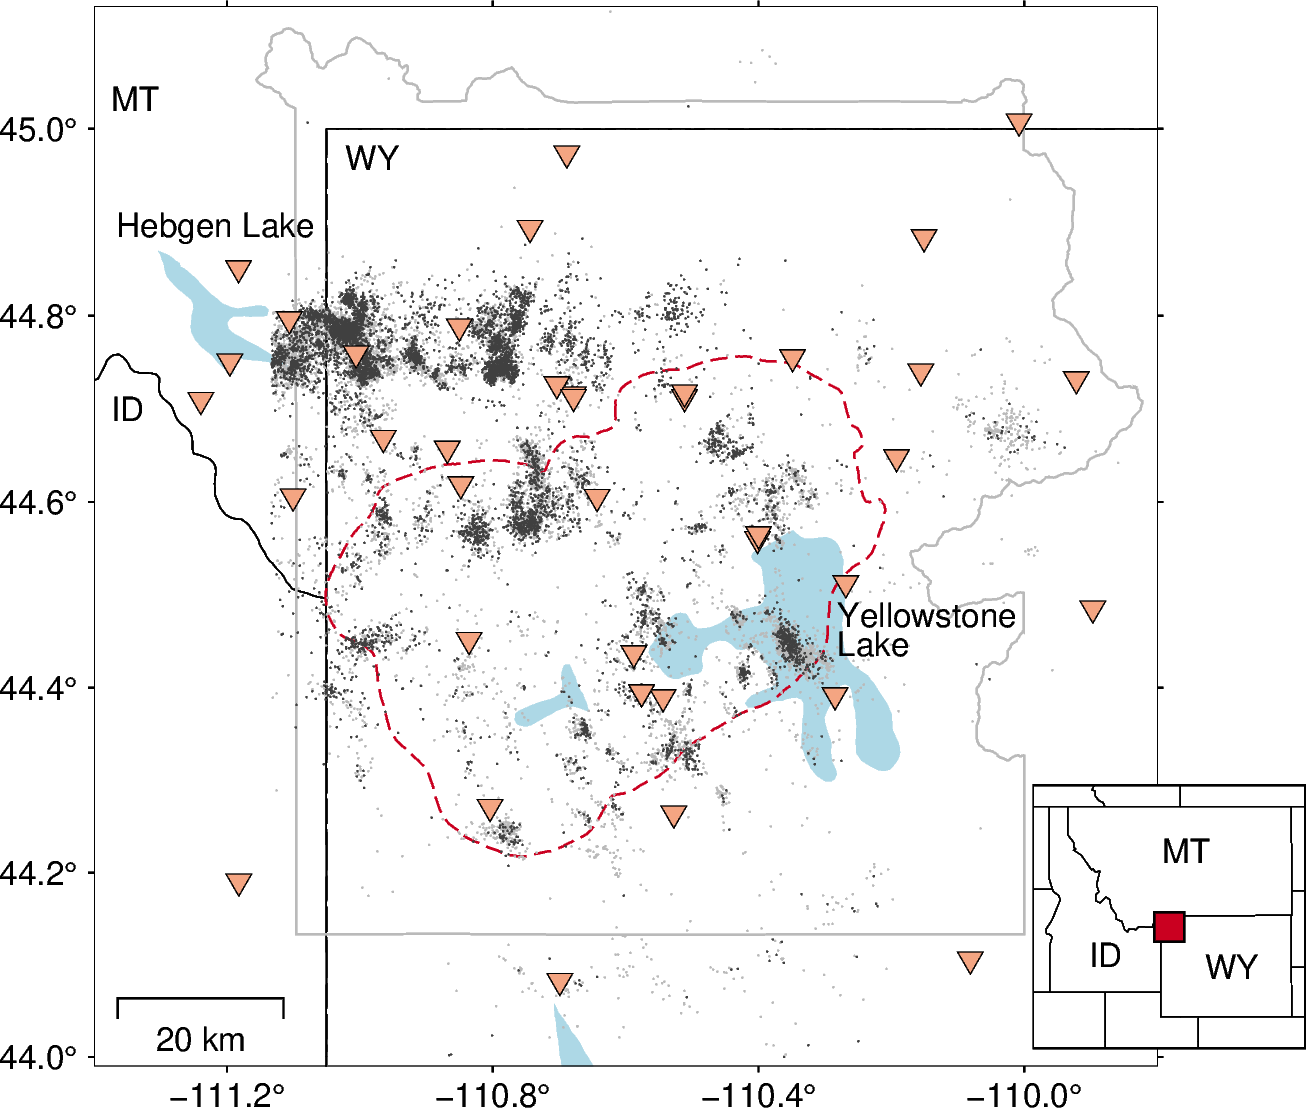

In [43]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
fig.plot(data=caldera, pen='0.5p,#ca0020,-')
fig.plot(data=ys_border, pen='0.5p,#bababa')
#fig.plot(data=uuss_auth_box, pen='0.5p,gray,-')

#
# Plot events
#
fig.plot(data=ev_cat_filt[ev_cat_filt['magnitude_type'] != 'l'][['event_lon', 'event_lat']], style='c0.5p', fill='#bababa')
fig.plot(data=ev_cat_filt[ev_cat_filt['magnitude_type'] == 'l'][['event_lon', 'event_lat']], style='c0.5p', fill='#404040')


#
# State labels, title, etc
#
fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

# fig.text(x=-111.25, y=44.88, text="Hebgen Lake", justify="CM", angle=-42, offset='-0.05c/-0.05c')
# fig.text(x=-110.2, y=44.40, text="Yellowstone Lake", justify="RM", angle=-73, offset='0.20c/-0.35c', fill='white')
fig.text(x=-111.2, y=44.9, text="Hebgen Lake", justify="CM", offset="-0.1/-0.02")
with open('ysl.txt', 'w') as fp:
    fp.write('''\
> -110.15 44.45 7p 0.1i l
Yellowstone Lake
''')
fig.text(textfiles='ysl.txt', M=True, offset='0.02c/0.1c')

#
#Plot stations
#
fig.plot(data=station_df[['receiver_lon', 'receiver_lat']], style='i0.25c', fill='#f4a582', pen='0.2p,black')


with fig.inset(position="jBR+o-1.25/0.15+w2.3c/2.23c", box="+p0.3,black+gwhite"):
    fig.coast(
        region = STUDYREG + np.array([-6.5, 6.5, -4.25, 4.6]),
        projection = f"M5.4/9/?",
        borders = [1, 2]
    )
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(frame=["nsew"])
        
    fig.plot(data=[[STUDYREG[0], STUDYREG[2], STUDYREG[1], STUDYREG[3]]], style="r+s", fill="#ca0020", pen="0.5p,black")

    fig.text(
        x = -107.25, 
        y = 43,
        text = "WY",
    )
    fig.text(
        x = -114, 
        y = 43.5, 
        text = "ID", 
    )
    fig.text(
        x = -109.7, 
        y = 47.4, 
        text = "MT", 
    )

fig.show()


Network magnitude vs station magnitude for local magnitudes 
- plot A) YP21
- plot B) UUSS

In [46]:
(ypml_amps_filt['Event-Mean-YPML-S'] - ypml_amps_filt['Station-YPML-S']).describe()

count    2.154500e+04
mean     9.533129e-19
std      1.652798e-01
min     -1.025347e+00
25%     -1.007345e-01
50%      3.018232e-03
75%      1.040545e-01
max      1.049844e+00
dtype: float64

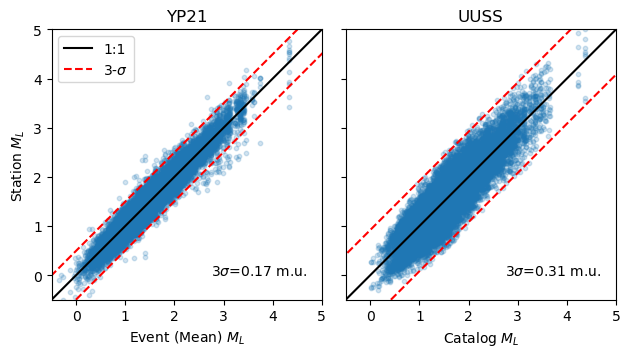

In [163]:
def plot_compare_net_stat_mags(df, title1, title2):
    fig, ax = plt.subplots(1, 2)

    sscale = 3
    oneone= np.arange(-0.5, 5.5, 0.5)
    text_pos = (2.75, 0)
    lims = [-0.5, 5]
    xlabel1 = r'Event (Mean) $M_L$'
    xlabel2 = r'Catalog $M_L$'
    ylabel = r'Station $M_L$'
    std_line_color = 'r'
    oneone_line_color = 'k'
    circle_color = 'C0'
    circle_alpha=0.2
    circle_size = 10

    def plot_box( ax, x_col_name, y_col_name, title, xlabel):
        if type(y_col_name) == list:
            y = (df[y_col_name[0]] + df[y_col_name[1]])/2
        else:
            y = df[y_col_name]
        diff = df[x_col_name] - y
        std = np.std(diff)
        ax.scatter(df[x_col_name], y, s=circle_size, alpha=circle_alpha, color=circle_color)
        ax.plot(oneone, oneone, color=oneone_line_color, label='1:1')
        ax.plot(oneone + std*sscale, oneone, color=std_line_color, linestyle='--', label=f"{sscale}-$\sigma$")
        ax.plot(oneone - std*sscale, oneone, color=std_line_color, linestyle='--')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.text(text_pos[0], text_pos[1], f"{sscale}$\sigma$={std:0.2f} m.u.")

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

    # YP21 mags
    plot_box(ax[0], 'Event-Mean-YPML-S','Station-YPML-S', title1, xlabel1)
    # UUSS Mags
    plot_box(ax[1], 'CatMag',['SMLE', 'SMLN'], title2, xlabel2)

    ax[1].set_yticklabels([])
    ax[0].set_ylabel(ylabel)
    ax[0].legend()

    fig.tight_layout()
plot_compare_net_stat_mags(ypml_amps_filt, 'YP21', 'UUSS')

(-0.5, 5.0)

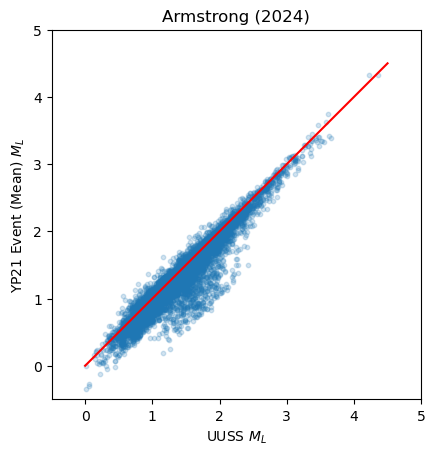

In [164]:
fig, ax = plt.subplots(1)

# My Cat vs UUSS
ax.scatter(ypml_cat_filt['CatMag'], ypml_cat_filt['Event-Mean-YPML-S'], s=10, alpha=0.2)
ax.plot(np.arange(0, 5., 0.5), np.arange(0, 5., 0.5), color='r')
ax.set_xlabel(r'UUSS $M_L$')
ax.set_ylabel(r'YP21 Event (Mean) $M_L$')
ax.set_title("Armstrong (2024)")
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-0.5, 5])
ax.set_ylim([-0.5, 5])